<a href="https://colab.research.google.com/github/gordicaleksa/get-started-with-JAX/blob/main/Tutorial_3_JAX_Neural_Network_from_Scratch_Colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# MLP training on MNIST

In [13]:
import numpy as np
import jax.numpy as jnp
from jax.scipy.special import logsumexp
import jax
from jax import jit, vmap, pmap, grad, value_and_grad
import matplotlib.pyplot as plt
from torchvision.datasets import MNIST
from torch.utils.data import DataLoader

In [7]:
seed = 0
mnist_img_size = (28, 28)

def init_MLP(layer_widths, parent_key, scale=0.01):

    params = []
    keys = jax.random.split(parent_key, num=len(layer_widths)-1)

    for in_width, out_width, key in zip(layer_widths[:-1], layer_widths[1:], keys):
        weight_key, bias_key = jax.random.split(key)
        params.append([
                       scale*jax.random.normal(weight_key, shape=(out_width, in_width)),
                       scale*jax.random.normal(bias_key, shape=(out_width,))
                       ]
        )

    return params

# test
key = jax.random.PRNGKey(seed)
MLP_params = init_MLP([784, 512, 256, 10], key)
print(jax.tree_map(lambda x: x.shape, MLP_params))

[[(512, 784), (512,)], [(256, 512), (256,)], [(10, 256), (10,)]]


In [8]:
def MLP_predict(params, x):
    hidden_layers = params[:-1]

    activation = x
    for w, b in hidden_layers:
        activation = jax.nn.relu(jnp.dot(w, activation) + b)

    w_last, b_last = params[-1]
    logits = jnp.dot(w_last, activation) + b_last # No activation at the last layer. Instead, we just out put the value and call it "logits".

    # log(exp(o1)) - log(sum(exp(o1), exp(o2), ..., exp(o10)))
    # log( exp(o1) / sum(...) )
    # The log-softmax of oi can be expressed as log(exp(oi) / sum(exp(oj) for oj in logits)), which simplifies to 
    # oi - log(sum(exp(oj) for oj in logits)), this is implemented as `logits - logsumexp(logits)`.
    # 
    return logits - logsumexp(logits)

# tests

# test single example

dummy_img_flat = np.random.randn(np.prod(mnist_img_size))
print(dummy_img_flat.shape)

prediction = MLP_predict(MLP_params, dummy_img_flat)
print(prediction.shape)

# test batched function

# None means that the corresponding argument to the function should not be vectorized. 
# This is used for arguments that do not change with each element of the batch. 
# In the context of MLP_predict, this is used for params, indicating that the model parameters are shared across the entire batch of inputs and should not be treated as having a batch dimension.
# 0 means that the first dimension (dimension at index 0) of the corresponding argument is the batch dimension, and the function should be mapped along this dimension. In this case, it's used for the x argument, indicating that each element along the first dimension of x is a separate data point, and the function should be applied to each data point in parallel.
batched_MLP_predict = vmap(MLP_predict, in_axes=(None, 0))

dummy_imgs_flat = np.random.randn(16, np.prod(mnist_img_size))
print(dummy_imgs_flat.shape)
predictions = batched_MLP_predict(MLP_params, dummy_imgs_flat)
print(predictions.shape)

(784,)
(10,)
(16, 784)
(16, 10)


In [9]:
def custom_transform(x):
    return np.ravel(np.array(x, dtype=np.float32))

def custom_collate_fn(batch):
    transposed_data = list(zip(*batch))

    labels = np.array(transposed_data[1])
    imgs = np.stack(transposed_data[0])

    return imgs, labels

batch_size = 128
train_dataset = MNIST(root='train_mnist', train=True, download=True, transform=custom_transform)
test_dataset = MNIST(root='test_mnist', train=False, download=True, transform=custom_transform)

train_loader = DataLoader(train_dataset, batch_size, shuffle=True, collate_fn=custom_collate_fn, drop_last=True)
test_loader = DataLoader(test_dataset, batch_size, shuffle=False, collate_fn=custom_collate_fn, drop_last=True)

# test
batch_data = next(iter(train_loader))
imgs = batch_data[0]
lbls = batch_data[1]
print(imgs.shape, imgs[0].dtype, lbls.shape, lbls[0].dtype)

# optimization - loading the whole dataset into memory
train_images = jnp.array(train_dataset.data).reshape(len(train_dataset), -1)
train_lbls = jnp.array(train_dataset.targets)

test_images = jnp.array(test_dataset.data).reshape(len(test_dataset), -1)
test_lbls = jnp.array(test_dataset.targets)

100%|██████████| 9912422/9912422 [00:00<00:00, 76335992.41it/s]


Extracting train_mnist/MNIST/raw/train-images-idx3-ubyte.gz to train_mnist/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 38249350.75it/s]

Extracting train_mnist/MNIST/raw/train-labels-idx1-ubyte.gz to train_mnist/MNIST/raw




100%|██████████| 1648877/1648877 [00:00<00:00, 20517549.36it/s]


Extracting train_mnist/MNIST/raw/t10k-images-idx3-ubyte.gz to train_mnist/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 19321023.09it/s]

Extracting train_mnist/MNIST/raw/t10k-labels-idx1-ubyte.gz to train_mnist/MNIST/raw



100%|██████████| 9912422/9912422 [00:00<00:00, 77968395.43it/s]


Extracting test_mnist/MNIST/raw/train-images-idx3-ubyte.gz to test_mnist/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 85972813.22it/s]

Extracting test_mnist/MNIST/raw/train-labels-idx1-ubyte.gz to test_mnist/MNIST/raw




100%|██████████| 1648877/1648877 [00:00<00:00, 18937167.37it/s]


Extracting test_mnist/MNIST/raw/t10k-images-idx3-ubyte.gz to test_mnist/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 15770305.27it/s]


Extracting test_mnist/MNIST/raw/t10k-labels-idx1-ubyte.gz to test_mnist/MNIST/raw

(128, 784) float32 (128,) int64


In [14]:
num_epochs = 5

def loss_fn(params, imgs, gt_lbls):
    predictions = batched_MLP_predict(params, imgs)

    return -jnp.mean(predictions * gt_lbls)

def accuracy(params, dataset_imgs, dataset_lbls):
    pred_classes = jnp.argmax(batched_MLP_predict(params, dataset_imgs), axis=1)
    return jnp.mean(dataset_lbls == pred_classes)

@jit
def update(params, imgs, gt_lbls, lr=0.01):
    loss, grads = value_and_grad(loss_fn)(params, imgs, gt_lbls)

    return loss, jax.tree_map(lambda p, g: p - lr*g, params, grads)

# Create a MLP
MLP_params = init_MLP([np.prod(mnist_img_size), 512, 256, len(MNIST.classes)], key)

for epoch in range(num_epochs):

    for cnt, (imgs, lbls) in enumerate(train_loader):

        gt_labels = jax.nn.one_hot(lbls, len(MNIST.classes))
        
        loss, MLP_params = update(MLP_params, imgs, gt_labels)
        
        if cnt % 50 == 0:
            print(loss)

    print(f'Epoch {epoch}, train acc = {accuracy(MLP_params, train_images, train_lbls)} test acc = {accuracy(MLP_params, test_images, test_lbls)}')


0.23419312
0.09697534
0.06015554
0.03340227
0.034173828
0.045981716
0.039579112
0.04436487
0.026862247
0.032681305
Epoch 0, train acc = 0.9142833352088928 test acc = 0.9180999994277954
0.018756187
0.024580471
0.016545815
0.033730764
0.02946031
0.017116528
0.0281703
0.018810794
0.027263302
0.023317039
Epoch 1, train acc = 0.9345499873161316 test acc = 0.934499979019165
0.02385467
0.018134682
0.02428659
0.012522365
0.028347528
0.031411406
0.025721217
0.014370153
0.016760916
0.023270069
Epoch 2, train acc = 0.947533369064331 test acc = 0.9441999793052673
0.016118346
0.012706709
0.019631738
0.016694682
0.012801585
0.01608566
0.015338488
0.008204472
0.019639043
0.016759217
Epoch 3, train acc = 0.9544333219528198 test acc = 0.9514999985694885
0.015931595
0.013519863
0.02422557
0.012220651
0.011797677
0.017081475
0.012404169
0.016098863
0.02590847
0.014678563
Epoch 4, train acc = 0.9608166813850403 test acc = 0.9553999900817871


(28, 28)
pred 7
gt 7


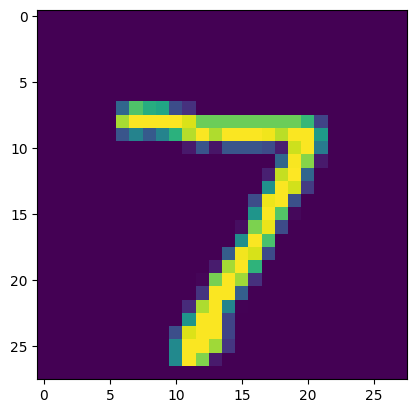

In [15]:
imgs, lbls = next(iter(test_loader))
img = imgs[0].reshape(mnist_img_size)
gt_lbl = lbls[0]
print(img.shape)

import matplotlib.pyplot as plt

pred = jnp.argmax(MLP_predict(MLP_params, np.ravel(img)))
print('pred', pred)
print('gt', gt_lbl)

plt.imshow(img); plt.show()

# Visualizations

(512, 784)
(28, 28)


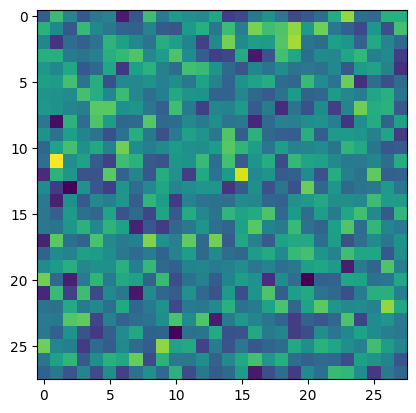

In [16]:
w = MLP_params[0][0]
print(w.shape)

w_single = w[500, :].reshape(mnist_img_size)
print(w_single.shape)
plt.imshow(w_single); plt.show()

(128, 256)


KeyError: 7

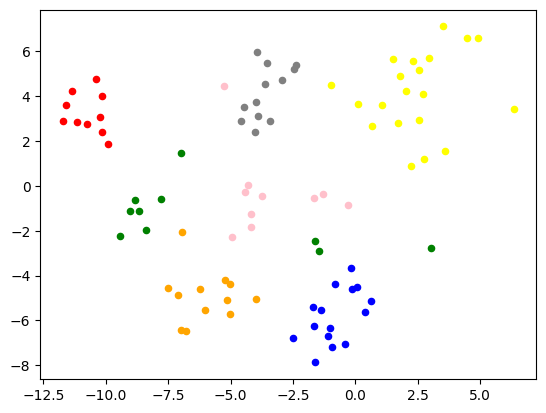

In [19]:
# todo: visualize embeddings using t-SNE

from sklearn.manifold import TSNE

def fetch_activations(params, x):
    hidden_layers = params[:-1]

    activation = x
    for w, b in hidden_layers:
        activation = jax.nn.relu(jnp.dot(w, activation) + b)

    return activation

batched_fetch_activations = vmap(fetch_activations, in_axes=(None, 0))
imgs, lbls = next(iter(test_loader))

batch_activations = batched_fetch_activations(MLP_params, imgs)
print(batch_activations.shape)  # (128, 2)

t_sne_embeddings = TSNE(n_components=2, perplexity=30,).fit_transform(batch_activations)
cora_label_to_color_map = {0: "red", 1: "blue", 2: "green", 3: "orange", 4: "yellow", 5: "pink", 6: "gray"}

for class_id in range(10):
    plt.scatter(t_sne_embeddings[lbls == class_id, 0], t_sne_embeddings[lbls == class_id, 1], s=20, color=cora_label_to_color_map[class_id])
plt.show()

In [20]:
# todo: dead neurons

def fetch_activations2(params, x):
    hidden_layers = params[:-1]
    collector = []

    activation = x
    for w, b in hidden_layers:
        activation = jax.nn.relu(jnp.dot(w, activation) + b)
        collector.append(activation)

    return collector

batched_fetch_activations2 = vmap(fetch_activations2, in_axes=(None, 0))

imgs, lbls = next(iter(test_loader))

MLP_params2 = init_MLP([np.prod(mnist_img_size), 512, 256, len(MNIST.classes)], key)

batch_activations = batched_fetch_activations2(MLP_params2, imgs)
print(batch_activations[1].shape)  # (128, 512/256)

dead_neurons = [np.ones(act.shape[1:]) for act in batch_activations]

for layer_id, activations in enumerate(batch_activations):
    dead_neurons[layer_id] = np.logical_and(dead_neurons[layer_id], (activations == 0).all(axis=0))

for layers in dead_neurons:
    print(np.sum(layers))

(128, 256)
0
7


# Parallelization